In [597]:
import cv2
import numpy as np
import json
import pandas as pd
from matplotlib import pyplot as plt

# Define Image Data Structure

In [598]:
class ImageData:
    def __init__(self, filename, img, actual_polygons):
        self.filename = filename
        self.img = img
        self.watershed_iou = 0
        self.improved_watershed_iou = 0
        self.actual_mask = np.zeros(self.img.shape[:2], np.uint8)
        self.watershed_mask = np.zeros(self.img.shape[:2], np.uint8)
        self.improved_watershed_mask = np.zeros(self.img.shape[:2], np.uint8)
        for index, polygon in enumerate(actual_polygons):
            cv2.fillPoly(self.actual_mask, [polygon], index + 1)

    def add_watershed_mask(self, watershed_mask):
        self.watershed_mask = cv2.bitwise_or(
            self.watershed_mask, watershed_mask)

    def add_improved_watershed_mask(self, improved_watershed_mask):
        self.improved_watershed_mask = cv2.bitwise_or(
            self.improved_watershed_mask, improved_watershed_mask)

    def show(self):
        plt.imshow(self.img)
        plt.show()

    def show_image(self, image):
        plt.imshow(image)
        plt.show()

    def show_comparison(self):
        _, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(self.actual_mask)
        ax[1].imshow(self.watershed_mask)
        ax[2].imshow(self.improved_watershed_mask)
        plt.show()

    def calculate_iou(self):
        intersection = cv2.bitwise_and(
            self.actual_mask, self.watershed_mask)
        union = cv2.bitwise_or(self.actual_mask, self.watershed_mask)
        iou = cv2.countNonZero(intersection) / cv2.countNonZero(union)
        self.watershed_iou = iou

        intersection = cv2.bitwise_and(
            self.actual_mask, self.improved_watershed_mask)
        union = cv2.bitwise_or(self.actual_mask, self.improved_watershed_mask)
        iou = cv2.countNonZero(intersection) / cv2.countNonZero(union)
        self.improved_watershed_iou = iou

# Load the Datasets

In [599]:
# Initialize empty list of image data
image_datas = []

# Load labels from JSON
labels = json.load(open('datasets/labels.json'))

# Load image data
for index, image_datas_raw in enumerate(labels):
    filename = image_datas_raw['data']['image']
    img = cv2.imread('datasets/' + filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    polygons = []
    for annotation in image_datas_raw['annotations']:
        for result in annotation['result']:
            polygons.append(
                np.array(np.matmul(result['value']['points'], [
                         [img.shape[1] / 100, 0], [0, img.shape[0] / 100]]), np.int32)
            )
    image_datas.append(ImageData(filename, img, polygons))

In [600]:
# for image_data in image_datas:
#     image_data.show()

# Watershed Segmentation

In [601]:
# def im_show(img, title):
#     plt.title(title)
#     plt.imshow(img)
#     plt.show()


def im_show(img, title):
    return


for image_data in image_datas:
    image = image_data.img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    im_show(gray, 'gray')

    # Menggunakan threshold untuk menentukan batas objek
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Menerapkan transformasi morfologi untuk membersihkan gambar
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Mengaplikasikan operasi sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    im_show(sure_bg, 'sure_bg')

    # Menemukan sure foreground area menggunakan transformasi distansi
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Mencari unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    im_show(sure_fg, 'sure_fg')
    im_show(unknown, 'unknown')

    # Membuat label untuk komponen yang terhubung
    ret, markers = cv2.connectedComponents(sure_fg)

    im_show(markers, 'markers connected components')

    # Menambahkan 1 ke setiap label sehingga menjadi 1, bukan 0
    markers = markers + 1

    im_show(markers, 'markers + 1')

    # Menandai area tidak pasti dengan 0
    markers[unknown == 255] = 0

    im_show(markers, 'markers unknown')

    # Menerapkan algoritma watershed
    cv2.watershed(image, markers)
    markers = markers - 1
    markers[markers < 0] = 0

    im_show(markers, 'markers watershed')
    im_show(image, 'image watershed')

    image_data.add_watershed_mask(np.array(markers, np.uint8))

# Visualize the Results

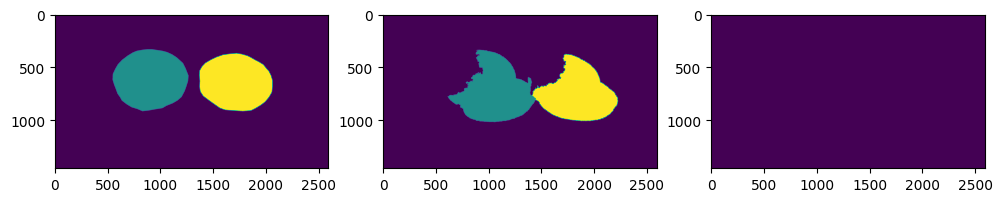

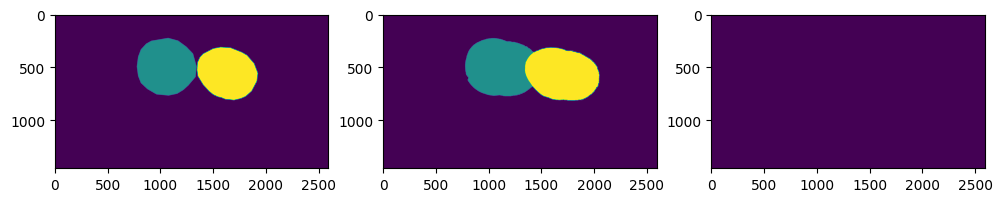

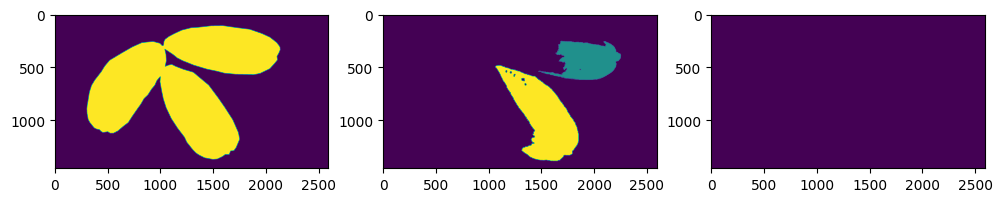

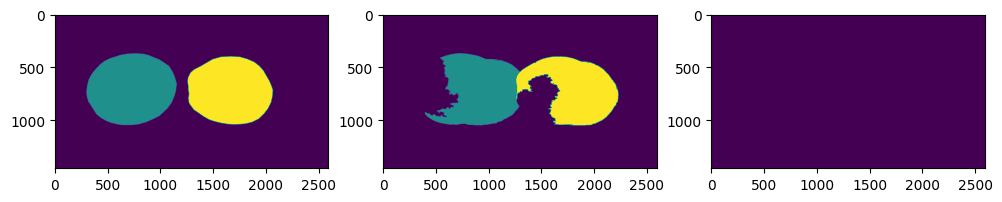

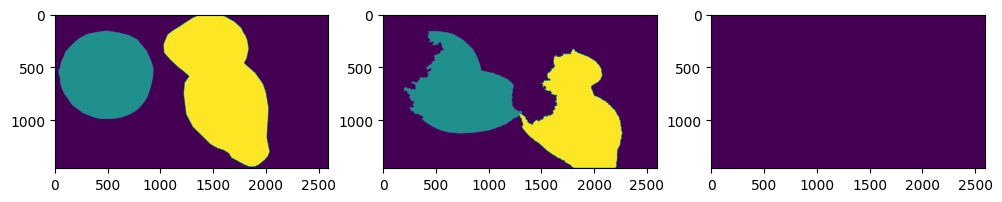

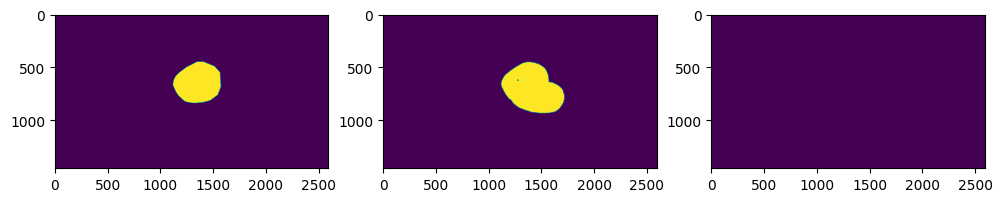

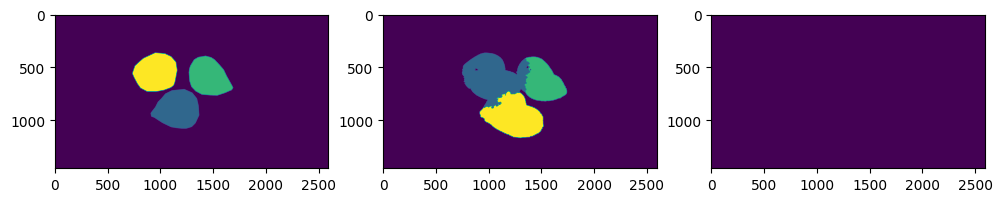

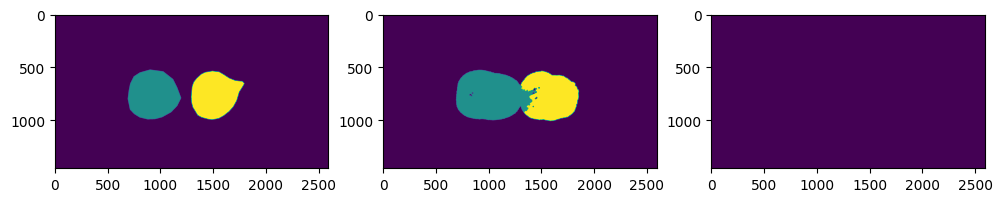

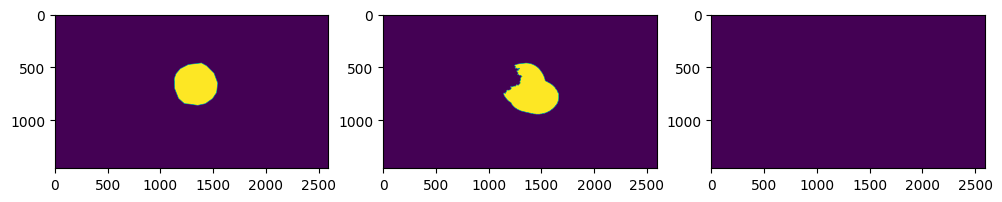

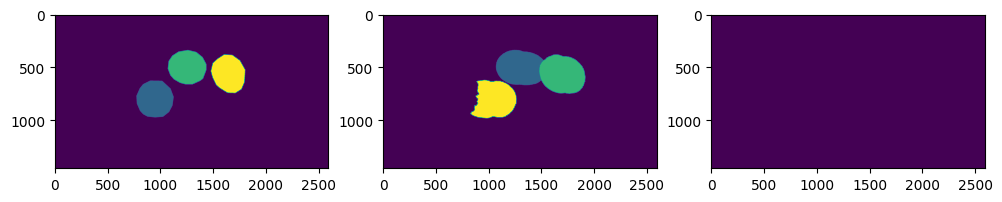

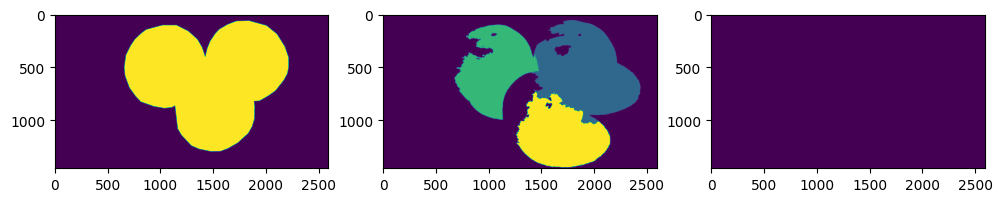

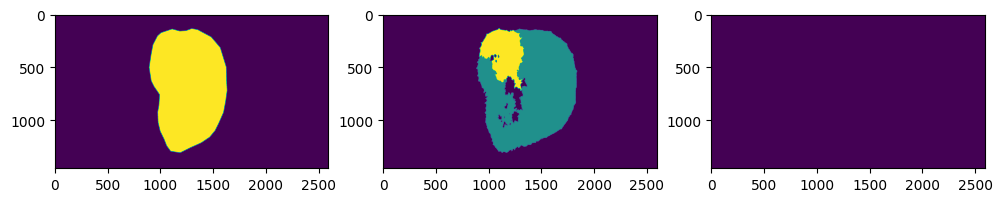

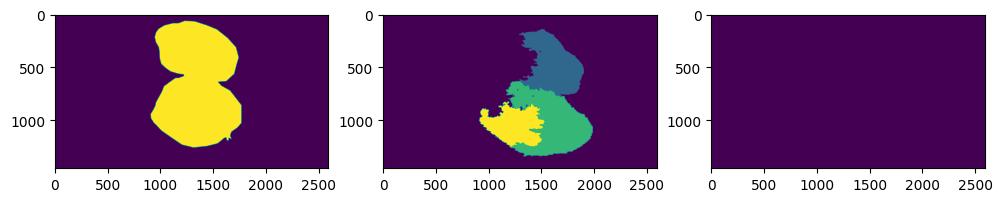

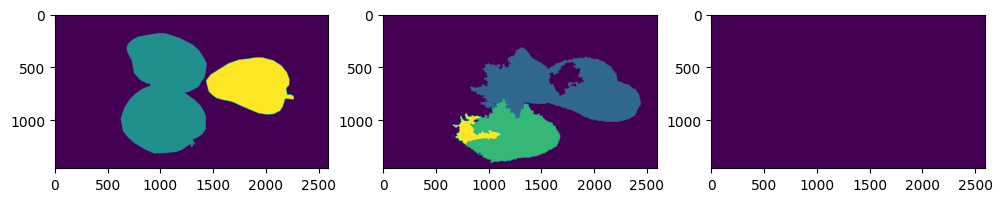

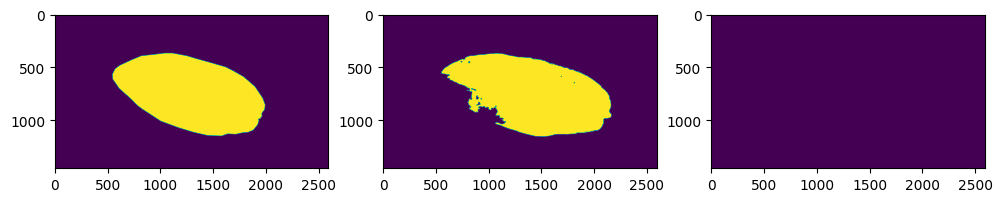

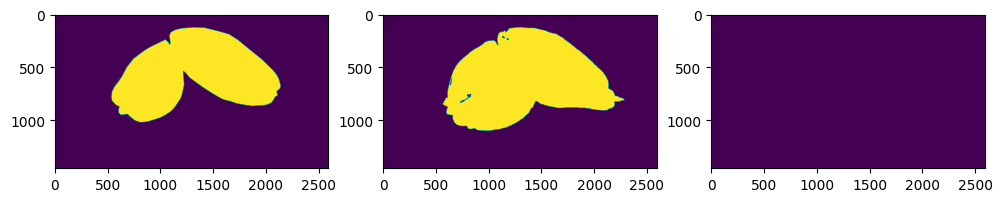

In [602]:
for image_data in image_datas:
    image_data.show_comparison()

In [603]:
iou_results = []
for image_data in image_datas:
    image_data.calculate_iou()
    iou_results.append([image_data.filename, image_data.watershed_iou,
                        image_data.improved_watershed_iou])

df = pd.DataFrame(iou_results, columns=[
                  'Filename', 'Watershed IoU', 'Improved Watershed IoU'])

df

,Filename,Watershed IoU,Improved Watershed IoU
0,ambarella044.JPG,0.504259,0.0
1,sapodilla041.JPG,0.812119,0.0
2,star_fruit050.JPG,0.086211,0.0
3,ambarella041.JPG,0.569947,0.0
4,avocado168.JPG,0.417023,0.0
5,salak002.JPG,0.661230,0.0
6,salak006.JPG,0.674678,0.0
7,salak163.JPG,0.709803,0.0
8,sapodilla122.JPG,0.532778,0.0
9,sapodilla127.JPG,0.409032,0.0
